In [12]:
import os 
import datetime
# The shutil module in Python provides many functions of high-level operations on files and collections of files.
# This module helps in automating process of copying and removal of files and directories.
import shutil 

import tensorflow as tf 
import numpy as np
import pandas as pd 
from tensorflow import keras # Tensorflow keras API 
import matplotlib.pyplot as plt # For Ploting Graphs

from tensorflow.keras.models import Sequential # Sequential API 

from tensorflow.keras.layers import Dense , DenseFeatures # Hidden Layers
from tensorflow.keras.callbacks import TensorBoard # for saving our callbacks we use TensorBoard

In [2]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]

LABEL_COLUMN = "fare_amount"

DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ["pickup_datetime", "key"]

def features_and_labels(row_data):
  labels = row_data.pop(LABEL_COLUMN)
  features = row_data

  for unwanter_cols in UNWANTED_COLS:
    features.pop(unwanter_cols)

  return features,labels


def create_dataset(pattern, batch_size = 1, mode = "eval"):
  dataset = tf.data.experimental.make_csv_dataset(pattern , batch_size , CSV_COLUMNS , DEFAULTS)

  dataset = dataset.map(features_and_labels)

  if mode == "train":
    dataset = dataset.shuffle(buffer_size = 1000).repeat()

  dataset = dataset.prefetch(1)
  return dataset

## Building a Simple Keras DNN Model

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common types of feature engineering on your raw data. For example, you can one-hot encode categorical data, create feature crosses, embeddings and more. 

In our case we won't do any feature engineering. However, we still need to create a list of feature columns to specify the numeric values which will be passed on to our model. To do this, we use tf.feature_column.numeric_column()

We use a python dictionary comprehension to create the feature columns for our model, which is just an elegant alternative to a for loop.

In [3]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count'
]

feature_columns = {
    colname : tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
}


Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model.

In [6]:
model = Sequential([
            DenseFeatures(feature_columns=feature_columns.values()),
            Dense(units = 32, activation="relu", name="h1"),
            Dense(units = 8 , activation="relu", name = "h2"),
            Dense(units = 1, activation="linear", name = "output")
])

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

- An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class.
- A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the Losses class (such as categorical_crossentropy or mse), or it can be a custom objective function.
- A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.


We will add an additional custom metric called rmse to our list of metrics which will return the root mean square error.

In [7]:
def rmse(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model.compile(optimizer="adam", loss="mse",metrics=["mse",rmse])

## Model Training

To train your model, Keras provides three functions that can be used:

- .fit() for training a model for a fixed number of epochs (iterations on a dataset).
- .fit_generator() for training a model on data yielded batch-by-batch by a generator
- .train_on_batch() runs a single gradient update on a single batch of data.


The .fit() function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use .fit_generator() instead. The .train_on_batch() method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use .fit to train our model. Our create_dataset function above generates batches of training examples, so we could also use .fit_generator. In fact, when calling .fit the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically .fit_generator for training.

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

We refer you the the blog post ML Design Pattern #3: Virtual Epochs for further details on why express the training in terms of NUM_TRAIN_EXAMPLES and NUM_EVALS and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.

In [8]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLE = 10000*5
NUM_EVAL = 50
NUM_EVAL_EXAMPLES = 10000


trainds = create_dataset(pattern="/content/drive/MyDrive/Datasets/Taxi/taxi-train.csv",
                         batch_size=TRAIN_BATCH_SIZE,
                         mode="train")
evalds = create_dataset(pattern="/content/drive/MyDrive/Datasets/Taxi/taxi-valid.csv",
                         batch_size=TRAIN_BATCH_SIZE,
                         mode="eval").take(NUM_EVAL_EXAMPLES//1000)


There are various arguments you can set when calling the .fit method. Here x specifies the input data which in our case is a tf.data dataset returning a tuple of (inputs, targets). The steps_per_epoch parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the callback argument we specify a Tensorboard callback so we can inspect Tensorboard after training.

In [9]:
steps_per_epoch = NUM_TRAIN_EXAMPLE // (TRAIN_BATCH_SIZE * NUM_EVAL)

LOGDIR = "./taxi_trained"

history = model.fit(x= trainds,
                    steps_per_epoch = steps_per_epoch,
                    epochs = NUM_EVAL,
                    validation_data = evalds,
                    callbacks=[TensorBoard(LOGDIR)])

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - ETA: 0s - loss: 532.0053 - mse: 532.0053 - rmse: 23.0652WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('pickup_longitude', <tf.Tensor 'ExpandDims_4:0' shape=(1000, 1) dtype=float32>), ('pickup_latitude', <tf.Tensor 'ExpandDims_3:0' shape=(1000, 1) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'ExpandDims_1:0' shape=(1000, 1) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'ExpandDims:0' shape=(1000, 1) dtype=float32>), ('passenger_count', <tf.Tensor 'ExpandDims_2:0' shape=(1000, 1) dtype=float32>)])
Consider rewriting this model with the Functional API.
1/1 [==============================] - 1s 1s/step - loss: 532.0053 - mse: 532.0053 - rmse: 23.0652 - val_loss: 429.0380 - val_mse: 429.0380 - val_rmse: 20.7119
Ep

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________



Running .fit (or .fit_generator) returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

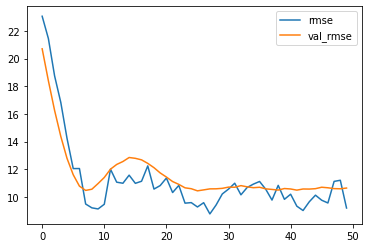

In [13]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

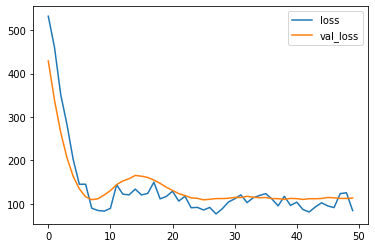

In [14]:
LOSS_COLS = ['loss', 'val_loss']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[LOSS_COLS].plot()

## Making Predictions with our Model

To make predictions with our trained model, we can call the predict method, passing to it a dictionary of values. The steps parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set steps=1 (setting steps=None would also work). Note, however, that if x is a tf.data dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [17]:
model.predict(x = {
                  "pickup_longitude": tf.convert_to_tensor([	-73.99259]),
                 "pickup_latitude": tf.convert_to_tensor([40.742957]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.989908]),
                 "dropoff_latitude": tf.convert_to_tensor([40.711053]),
                 "passenger_count": tf.convert_to_tensor([1.0])},
             steps=1)

array([[10.32478]], dtype=float32)